In [1]:
import sys
sys.path.append('..')
from utils import *
sys.path.append('../attacks/')
from fgsm import *
sys.path.append('../models/')
from torch import nn
import torch
from torchvision import transforms
import numpy as np
from torchvision import datasets
from torch import norm
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np

In [2]:
imgs = datasets.CIFAR10(root='/home/hancy/dataset/',train=False,transform=transforms.ToTensor(),download=True)

Files already downloaded and verified


In [3]:
model = torch.load('/home/hancy/code/adv_wm/models/pts/cifar_resnet_50.pt')
model = model.eval()
model = model.cuda()

In [4]:
wm = cv2.imread('../img/logo.jpg')
wm = cv2.cvtColor(wm,cv2.COLOR_BGR2RGB)
wm = cv2.resize(wm,dsize=(32,32),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
wm = transforms.ToTensor()(wm).cuda()

In [5]:
block_size = 4
alpha = 0.1
beta = 5/255
l1 = 0.001
l2 = 0.001
s_a = 0.000005
s_b = 0.0001
N = 100
alpha_max = 0.2
beta_max = 8/255

In [8]:
img = imgs[10][0].cuda()
target = torch.tensor([imgs[10][1]]).cuda()
pred_label = model(img.unsqueeze(0)).argmax().item()
perd_img,wm_extracted,a_res,b_res = fgsm_wm_opti(img,target,wm,model,alpha,beta,block_size,N,l1,l2,s_a,s_b,alpha_max,beta_max)
res = model(perd_img.unsqueeze(0))
perd_label = res.argmax().item()

In [7]:
filename = '/home/hancy/code/adv_wm/atk_result/fgsm_wm_cifar_resnet2210051536.txt'
check_result(filename)

8003
269
10.553886627320336
1.7362355990111829


In [10]:
def attack_and_record(filename: str,model: nn.Module, imgs:datasets, wm: Tensor):
    block_size = 4
    alpha = 0.1
    beta = 5/255
    l1 = 0.001
    l2 = 0.001
    s_a = 0.000005
    s_b = 0.0001
    N = 10
    alpha_max = 0.2
    beta_max = 8/255
    with open(filename,'a') as file:
        for i in tqdm(range(len(imgs)), desc='Processing'):
            img = imgs[i][0].cuda()
            target = torch.tensor([imgs[i][1]]).cuda()
            pred_label = model(img.unsqueeze(0)).argmax().item()
            perd_img,wm_extracted,a_res,b_res = fgsm_wm_opti(img,target,wm,model,alpha,beta,block_size,N,l1,l2,s_a,s_b,alpha_max,beta_max)
            res = model(perd_img.unsqueeze(0))
            perd_label = res.argmax().item()
            wm_l2_norm = norm(wm_extracted-wm).item()
            img_l2_norm = norm(perd_img-img).item()
            file.write('{},{},{},{},{},{},{},{}\n'.format(i,imgs[i][1],pred_label,perd_label,wm_l2_norm,img_l2_norm,a_res,b_res))

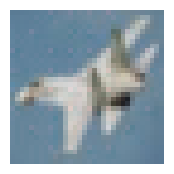

In [28]:
pltshow(perd_img)

In [29]:
perd_img, wm_extracted, a_res, b_res = fgsm_wm_opti(img,target,wm,model,alpha,beta,block_size,N,l1,l2,s_a,s_b,beta_max)
res = model(perd_img.unsqueeze(0))
perd_label = res.argmax().item()

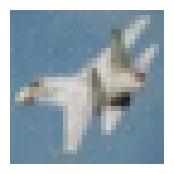

In [9]:
pltshow(perd_img)

In [6]:
def check_result(filename,direct_mode=False):
    cols = ['index','label','pred_label','perd_label','wm_l2','img_l2','alpha','beta']
    if(direct_mode):
        cols = ['index','label','pred_label','perd_label','wm_l2','img_l2']
    res = pd.read_csv(filename,names=cols,header=None)
    print((res['label'] == res['pred_label']).sum())
    print((res['label'] == res['perd_label']).sum())
    print(res['wm_l2'].sum() / res['wm_l2'].count())
    print(res['img_l2'].sum() / res['img_l2'].count())

In [11]:
def attack_and_record_direct(filename: str,model: nn.Module, imgs:datasets, wm: Tensor):
    block_size = 4
    alpha = 0.1
    beta = 5/255
    with open(filename,'a') as file:
        for i in tqdm(range(len(imgs)), desc='Processing'):
            img = imgs[i][0].cuda()
            target = torch.tensor([imgs[i][1]]).cuda()
            pred_label = model(img.unsqueeze(0)).argmax().item()
            perd_img = fgm_direct(img,target,wm,model,alpha,beta,block_size)
            wm_extracted = extract_wm(img,perd_img,alpha,block_size)
            res = model(perd_img.unsqueeze(0))
            perd_label = res.argmax().item()
            wm_l2_norm = norm(wm_extracted-wm).item()
            img_l2_norm = norm(perd_img-img).item()
            file.write('{},{},{},{},{},{}\n'.format(i,imgs[i][1],pred_label,perd_label,wm_l2_norm,img_l2_norm))

In [12]:
filename = '/home/hancy/code/adv_wm/atk_result/fgm_direct_cifar_alexnet2210041737.txt'
attack_and_record_direct(filename,model,imgs,wm)

Processing: 100%|██████████| 10000/10000 [01:58<00:00, 84.42it/s]


In [11]:
filename = '/home/hancy/code/adv_wm/atk_result/fgsm_wm_cifar_resnet2210051502.txt'
attack_and_record(filename,model,imgs,wm)

Processing: 100%|██████████| 10000/10000 [12:28<00:00, 13.36it/s]


In [14]:
check_result(filename)

7204
6593
5.132018263659297
1.2626146774053573


In [17]:
filename = '/home/hancy/code/adv_wm/atk_result/fgm_direct_cifar_alexnet2210041737.txt'
check_result(filename)

7204
6670
1.296062859558901
1.2658348120331764


In [ ]:
filename = '/home/hancy/code/adv_wm/atk_result/fgsm_direct_cifar_alexnet2210011644.txt'
attack_and_record_direct(filename,model,imgs,wm)

In [ ]:
check_result(filename,True)

In [ ]:
direct_cols = ['index','label','pred_label','perd_label','wm_l2','img_l2']

In [ ]:
res = pd.read_csv(filename,names=direct_cols,header=None)
print((res['label'] == res['perd_label']).sum())
print(res['wm_l2'].sum() / res['wm_l2'].count())
print(res['img_l2'].sum() / res['img_l2'].count())

In [ ]:
check_result(filename,True)

In [ ]:
check_result(filename,False)